In [1]:
# Load the functions required 

import math
from tqdm import tqdm
import numpy as np
from utils import RectangleRegion, integral_image
import pickle
import os 
dir_path = os.path.abspath('')

types_name = {1:'Two Vertical', 2:'Two Horizontal', 3:'Three Horizontal', 4:'Three Vertical', 5:'Four'}

class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def compute_feature(self, ii):
        return ii[self.y+self.height - 1][self.x+self.width - 1] + ii[self.y - 1][self.x - 1] - (ii[self.y+self.height - 1][self.x - 1] + ii[self.y - 1][self.x+self.width - 1])
    

def integral_image(image):
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape)
    for y in range(len(image)):
        for x in range(len(image[y])):
            s[y][x] = s[y-1][x] + image[y][x] if y-1 >= 0 else image[y][x]
            ii[y][x] = ii[y][x-1]+s[y][x] if x-1 >= 0 else s[y][x]
    return ii


class ViolaJones:
    
#     class Feature(Enum):
#         type_1 = 'Two Vertical'
#         type_2 = 'Two Horizontal'
#         type_3 = 'Three Horizontal'
#         type_4 = 'Three Vertical'
#         type_5 = 'Four'
        
    class WeakClassifier:
        def __init__(self, haar_feature, threshold, polarity):
            self.haar_feature = haar_feature
            self.threshold = threshold
            self.polarity = polarity
            self.acc = None
            
        def classify(self, x):
            return 1 if self.polarity * self.haar_feature.compute_features(x) < self.polarity * self.threshold else 0
    
    class HaarFeature:
        def __init__(self, harr_type, positive_regions, negative_regions, position, width, height):
            self.harr_type = harr_type
            self.positive_regions = positive_regions
            self.negative_regions = negative_regions
            self.position = position
            self.width = width
            self.height = height
            
        def compute_features(self, x):
            return sum([pos.compute_feature(x) for pos in self.positive_regions]) - sum([neg.compute_feature(x) for neg in self.negative_regions])
        
            
    def __init__(self, T):
        self.T = T
        self.alphas = []
        self.clfs = []
        self.test_acc = []
        self.test_fpr = []
        self.test_fnr = []
        
    def build_features(self, image_shape, max_height, max_width, load_feature=''):

        height, width = image_shape
        
        features = []
        type_count = [0] * 5
        
        if max_height == None:
            max_height = height
        else:
            max_height = min(max_height, height)
            
        if max_width == None:
            max_width = width
        else:
            max_width = min(max_width, width)
            
        for w in range(1, max_width + 1):
            for h in range(1, max_height + 1):
                cur_x = 0
                while cur_x + w <= width:
                    cur_y = 0
                    
                    while cur_y + h <= height:
                        
                        rec = RectangleRegion(cur_x, cur_y, w, h)

                        if cur_x + 2 * w <=  width:
                            # type 1 (two vertical) features
                            rec_right = RectangleRegion(cur_x + w, cur_y, w, h)
                            features.append(self.HaarFeature(1, [rec], [rec_right], (cur_x, cur_y), 2 * w, h))
                            type_count[0] += 1
                            
                            # type 4 (three vertical) features.
                            if cur_x + 3 * w <= width:
                                rec_right_right = RectangleRegion(cur_x + 2 * w, cur_y, w, h)
                                features.append(self.HaarFeature(4, [rec, rec_right_right], [rec_right], (cur_x, cur_y), 3 * w, h))
                                type_count[3] += 1
                                
                        # type 2 (two horizontal) features.
                        if cur_y + 2 * h <= height:
                            rec_bot = RectangleRegion(cur_x, cur_y + h, w, h)
                            features.append(self.HaarFeature(2, [rec], [rec_bot], (cur_x, cur_y), w, 2 * h))
                            type_count[1] += 1
                            
                            # type 3 (three horizontal) features.
                            if cur_y + 3 * h <= height:
                                rec_bot_bot = RectangleRegion(cur_x, cur_y + 2 * h, w, h)
                                features.append(self.HaarFeature(3, [rec, rec_bot_bot], [rec_bot], (cur_x, cur_y), w, 3 * h))
                                type_count[2] += 1
                                
                        # type 5 (four) features.
                        if (cur_x + 2 * w <=  width) and (cur_y + 2 * h <= height):
                            rec_bot_right = RectangleRegion(cur_x + w, cur_y + h, w, h)
                            features.append(self.HaarFeature(5, [rec, rec_bot_right], [rec_right, rec_bot], (cur_x, cur_y), 2 * w, 2 * h))
                            type_count[4] += 1
                            
                        cur_y += 1
                    cur_x += 1
                    
        # Print the feature summary 
        print('\t The total number of Haar Features is : ', len(features))
        print('\t There are ', type_count[0] ,' type 1 (two vertical) features.')
        print('\t There are ', type_count[1],' type 2 (two horizontal) features.')
        print('\t There are ', type_count[2],' type 3 (three horizontal) features.')
        print('\t There are ', type_count[3],' type 4 (three vertical) features.')
        print('\t There are ', type_count[4],' type 5 (four) features.')

        return features


    def apply_features(self, features, training_data, load_feature=''):
        y = np.array(list(map(lambda data: data[1], training_data)))

        if load_feature != '':
            print('Load calculated features...')
            with open(os.path.join(dir_path, load_feature), 'rb') as input:
                X = pickle.load(input)
                return X, y

        X = np.zeros((len(features), len(training_data)))
        i = 0
        for haar_feature in tqdm(features):
            X[i] = list(map(lambda data: haar_feature.compute_features(data[0]), training_data))
            i += 1


        if not os.path.exists(os.path.join(dir_path, './save_features/')):
            os.makedirs(os.path.join(dir_path, './save_features/'))

        print('Save precomputed feature at {}'.format(os.path.join(dir_path, 'save_features/features_{}'.format(len(features)))))
        with open(os.path.join(dir_path, 'save_features/features_{}'.format(len(features))), 'wb') as output:
            pickle.dump(X, output, pickle.HIGHEST_PROTOCOL)

        return X, y

    def train_weak(self, X, y, features, weights):
        total_pos, total_neg = 0, 0

        for w, label in zip(weights, y):
            if label == 1:
                total_pos += w
            else:
                total_neg += w

        classifiers = []
        total_features = X.shape[0]
        
        pbar = tqdm(total=total_features)
        
        for index, feature in enumerate(X):
            applied_feature = sorted(zip(weights, feature, y), key=lambda x: x[1])
            pos_seen, neg_seen = 0, 0
            pos_weights, neg_weights = 0, 0
            min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
            
            for w, f, label in applied_feature:
                error = min(neg_weights + total_pos - pos_weights, pos_weights + total_neg - neg_weights)
                if error < min_error:
                    min_error = error
                    best_feature = features[index]
                    best_threshold = f
                    best_polarity = 1 if pos_seen > neg_seen else -1
                if label == 1:
                    pos_seen += 1
                    pos_weights += w
                else:
                    neg_seen += 1
                    neg_weights += w
            clf = self.WeakClassifier(best_feature, best_threshold, best_polarity)
            classifiers.append(clf)
            
            pbar.update(1)
            
        return classifiers
        
    def select_best(self, classifiers, weights, training_data, crit='err'):
        # Pick the best classifier by emperical error, false positive rate, or false negative rate
        best_clf, best_err, best_acc = None, float('inf'), None
        best_fp_err, best_fn_err = float('inf'), float('inf')
        for clf in classifiers:
            err, acc = 0, []
            fp_err, fn_err = 0, 0
            
            for data, w in zip(training_data, weights):
                
                pred = clf.classify(data[0])
                c = abs(pred - data[1])
                acc.append(c)
                err += w * c
                
                if pred != data[1]:
                    if data[1] == 1:
                        fn_err += w
                    else:
                        fp_err += w
            err = err / len(training_data)   

            if crit == 'err' and err < best_err:
                best_clf, best_err, best_acc = clf, err, acc
            elif crit == 'fpr' and fp_err < best_fp_err:
                best_clf, best_err, best_acc = clf, err, acc
                best_fp_err = fp_err
            elif crit == 'fnr' and fn_err < best_fn_err:
                best_clf, best_err, best_acc = clf, err, acc
                best_fn_err = fn_err

        # Set training accuracy for the selected classifier
        best_clf.acc = sum(1 if i == 0 else 0 for i in best_acc) / len(best_acc)
        return best_clf, best_err, best_acc
    
    def train(self, training, testing, test_mode, max_height=8, max_width=8, crit='err', load_feature=''):
        
        pos_num = sum([tup[1] for tup in training])
        neg_num = len(training) - pos_num
        print('Face / None-Face : {}/{}'.format(pos_num, neg_num))
        rule = 'emperical error' if crit=='err' else 'false positive rate' if crit=='fpr' else 'false negative rate'
        print('Seleting classfiers based on', rule)
        weights = np.zeros(len(training))
        training_data = []
        
        print('Initialize the weights of {} weak classfiers...'.format(self.T))
        for x in range(len(training)):
            training_data.append((integral_image(training[x][0]), training[x][1]))
            if training[x][1] == 1:
                weights[x] = 1.0 / (2 * pos_num)
            else:
                weights[x] = 1.0 / (2 * neg_num)
                
        print('Build up Haar features filter of the size {}x{}'.format(max_height, max_width))
        features = self.build_features(training_data[0][0].shape, max_height, max_width)
        
        print('Precompute the Haar features of the training set...')
        X, y = self.apply_features(features, training_data, load_feature)
#         print(X.shape)
#         print(y.shape)
        print('Start Adaboost...')
    
        for t in range(self.T):
            print('Round {}/{}:'.format(t + 1, self.T))
            weights = weights / np.linalg.norm(weights)
            weak_classifiers = self.train_weak(X, y, features, weights)
            clf, total_error, accuracy = self.select_best(weak_classifiers, weights, training_data, crit)
            
            beta = total_error / (1.0 - total_error)
            for i in range(len(accuracy)):
                weights[i] = weights[i] * (beta ** (1 - accuracy[i]))
            alpha = math.log(1.0/beta)
            # if crit == 'err' or crit == 'fpr':
            #     beta = total_error / (1.0 - total_error)
            #     for i in range(len(accuracy)):
            #         weights[i] = weights[i] * (beta ** (1 - accuracy[i]))
            #     alpha = math.log(1.0/beta)
            # elif crit == 'fnr':
            #     alpha = math.log((1.0 - total_error) /total_error) *  (1 - fp_error) / fn_error
            #     for i in range(len(accuracy)):
            #         weights[i] = weights[i] * math.exp(alpha * accuracy[i])

            self.alphas.append(alpha)
            self.clfs.append(clf)
            
            if t == self.T - 1:
                self.test(testing, t + 1, test_mode)
            
    def classify(self, image):
        total = 0
        ii = integral_image(image)
        for alpha, clf in zip(self.alphas, self.clfs):
            total += alpha * clf.classify(ii)
        return 1 if total >= 0.5 * sum(self.alphas) else 0

    def cascade_classify(self, image): 
        for weak_clf in self.clfs:
            if weak_clf.classify(image) == 0:
                return 0
        return 1

    def test(self, testing, t, test_mode):
        total = len(testing)
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        
        for image, yVal in testing:
            pred = self.classify(image) if test_mode == 'single' else self.cascade_classify(image)
            if pred == yVal:
                if yVal == 1:
                    TP += 1
                else:
                    TN += 1
            else:
                if yVal == 1:
                    FN += 1
                else:
                    FP += 1
        
        self.test_acc.append((TP + TN) / total)
        self.test_fpr.append(FP / (FP + TN))
        self.test_fnr.append(FN / (FN + TP))
        
        print('Testing at Round {} :'.format(t))
        print('Total accuracy Rate: {} ({}/{})'.format((TP + TN) / total, TP + TN, total))
        print('False Positive Rate: {} ({}/{})'.format(FP / (FP + TN), FP, FP + TN))
        print('False Negative Rate: {} ({}/{}) \n'.format(FN / (FN + TP), FN, FN + TP))
        

In [2]:
# Load the functions required 

from PIL import Image
import numpy as np
import glob
%matplotlib inline

folders = {'non-faces' : 0, 'faces' : 1}

trainData = []
for folder, yVal in folders.items():
    for filename in glob.glob('./dataset/trainset/' + folder + '/*.png'):
        im = Image.open(filename)
        trainData.append((np.asarray(im, dtype="float32") / 255, yVal))
        
testData = []
for folder, yVal in folders.items():
    for filename in glob.glob('./dataset/testset/' + folder + '/*.png'):
        im = Image.open(filename)
        testData.append([np.asarray(im, dtype="float32") / 255, yVal])

# print([n[1] for n in trainData])
print('# of training images : ', len(trainData))
print('# of testing images : ', len(testData))

# of training images :  2499
# of testing images :  2473


In [3]:
# Load the functions required 

import pickle
import os 
dir_path = os.path.abspath('')

def save_model(model, file_name):
    with open(os.path.join(dir_path, file_name), 'wb') as output:
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def read_mode(file_name):
    with open(os.path.join(dir_path, file_name), 'rb') as input:
        model = pickle.load(input)
        return model

In [13]:
# Load the functions required 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def show_clf_detail(model, check_round=[1, 3, 5, 10], img=testData[2400][0]):
    for r in check_round :
        if r > model.T :
            break
        print('Feature number:', r)
        clf = model.clfs[r - 1]
        print('Type:', types_name[clf.haar_feature.harr_type])
        print('Position:', clf.haar_feature.position)
        print('Width:', clf.haar_feature.width)
        print('Length:', clf.haar_feature.height)
        print('Threshold:', clf.threshold)
        print('Training accuracy:', clf.acc)
        # Create figure and axes
        fig, ax = plt.subplots(1)
        # Display the image

        for rec in clf.haar_feature.positive_regions:
            # Create a Rectangle patch
            rect = patches.Rectangle((rec.x,rec.y), rec.width,rec.height,linewidth=1,edgecolor='y',facecolor='r')
            # Add the patch to the Axes
            ax.add_patch(rect)

        for rec in clf.haar_feature.negative_regions:
            # Create a Rectangle patch
            rect = patches.Rectangle((rec.x,rec.y), rec.width,rec.height,linewidth=1,edgecolor='b',facecolor='b')
            # Add the patch to the Axes
            ax.add_patch(rect)
        ax.imshow(img)
        print('---------------')
        
def classify_at_i(model, image, i):
    total = 0
    ii = integral_image(image)
    for alpha, clf in zip(model.alphas[:i], model.clfs[:i]):
        total += alpha * clf.classify(ii)
    return 1 if total >= 0.5 * sum(model.alphas[:i]) else 0

def test_all_round(model, testing):
    total = len(testing)
    test_acc = []
    test_fpr = []
    test_fnr = []
    for i in range(1, model.T + 1):
        TP = 0
        TN = 0
        FP = 0
        FN = 0

        for image, yVal in testing:
            if classify_at_i(model, image, i) == yVal:
                if yVal == 1:
                    TP += 1
                else:
                    TN += 1
            else:
                if yVal == 1:
                    FN += 1
                else:
                    FP += 1
        test_acc.append((TP + TN) / total)
        test_fpr.append(FP / (FP + TN))
        test_fnr.append(FN / (FN + TP))
        print('Testing at Round {} :'.format(i))
        print('Total accuracy Rate: {} ({}/{})'.format((TP + TN) / total, TP + TN, total))
        print('False Positive Rate: {} ({}/{})'.format(FP / (FP + TN), FP, FP + TN))
        print('False Negative Rate: {} ({}/{}) \n'.format(FN / (FN + TP), FN, FN + TP))    
    
    x_axis = [i for i in range(1, model.T + 1)]
    plt.plot(x_axis, test_acc, c='r',marker="v",ls='--',label='Total Accuracy')
    plt.plot(x_axis, test_fnr, c='b', marker="^",ls='--',label='False Negative Rate',fillstyle='none')
    plt.plot(x_axis, test_fpr, c='g', marker=(8,2,0),ls='--',label='False Positive Rate')
    plt.xlabel("Round")
    plt.ylabel("%")
    plt.legend()

Show the detail of model classifiers : 

Feature number: 1
Type: Two Vertical
Position: (8, 3)
Width: 2
Length: 8
Threshold: -0.43529412895441055
Training accuracy: 0.8635454181672669
---------------
Feature number: 3
Type: Two Vertical
Position: (7, 3)
Width: 4
Length: 7
Threshold: -0.9725490510463715
Training accuracy: 0.8031212484993998
---------------
Feature number: 5
Type: Four
Position: (0, 10)
Width: 12
Length: 2
Threshold: -0.9176470637321472
Training accuracy: 0.8035214085634254
---------------
Feature number: 10
Type: Four
Position: (0, 3)
Width: 8
Length: 4
Threshold: 2.4039216190576553
Training accuracy: 0.8283313325330132
---------------


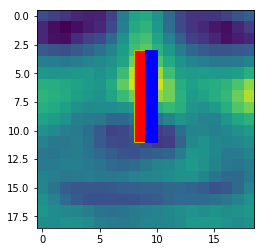

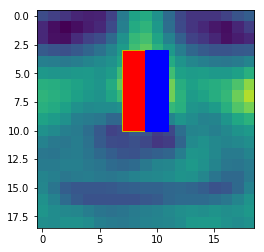

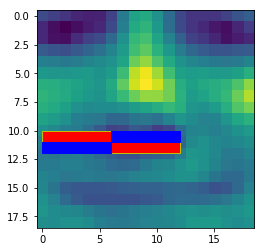

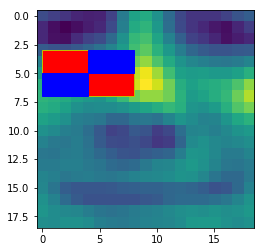

In [14]:
# Show the detail of model classifiers

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline
model = read_mode('./save_models/model_err_10')
print("Show the detail of model classifiers : \n")
show_clf_detail(model)

Show the testing accuracy of model : 
Testing at Round 1 :
Total accuracy Rate: 0.7868985038414881 (1946/2473)
False Positive Rate: 0.08495752123938032 (170/2001)
False Negative Rate: 0.7563559322033898 (357/472) 

Testing at Round 2 :
Total accuracy Rate: 0.24221593206631623 (599/2473)
False Positive Rate: 0.855072463768116 (1711/2001)
False Negative Rate: 0.3453389830508475 (163/472) 

Testing at Round 3 :
Total accuracy Rate: 0.7860897695107157 (1944/2473)
False Positive Rate: 0.0864567716141929 (173/2001)
False Negative Rate: 0.7542372881355932 (356/472) 

Testing at Round 4 :
Total accuracy Rate: 0.2547513141932875 (630/2473)
False Positive Rate: 0.8335832083958021 (1668/2001)
False Negative Rate: 0.3707627118644068 (175/472) 

Testing at Round 5 :
Total accuracy Rate: 0.8200566114031541 (2028/2473)
False Positive Rate: 0.059470264867566215 (119/2001)
False Negative Rate: 0.690677966101695 (326/472) 

Testing at Round 6 :
Total accuracy Rate: 0.8188435099069955 (2025/2473)
False P

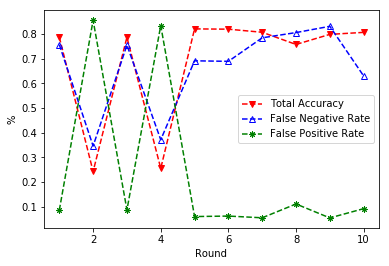

In [16]:
# Show the testing accuracy of model : 

print("Show the testing accuracy of model : ")
test_all_round(model, testData)

In [4]:
import math
import numpy as np
import pickle
import os 
dir_path = os.path.abspath('')

class ViolaJonesCascade:
    def __init__(self, layers):
        self.layers = layers
        self.clfs = []
        self.abandoned = []

    def train(self, training, testing, load_feature=''):
        pos, neg = [], []
        for ex in training: 
            if ex[1] == 1:
                pos.append(ex)
            else:
                neg.append(ex)
        for feature_num in self.layers:
            if len(neg) == 0:
                print("FPR = 0, stop the training!")
                break
            clf = ViolaJones(T=feature_num, v=False)
            clf.train(pos + neg, testing, load_feature=load_feature)
            self.clfs.append(clf)
            false_positives = []
            for ex in neg:
                if self.classify(ex[0]) == 1:
                    false_positives.append(ex)

            self.abandoned.append(len(neg) - len(false_positives))
            print('# of non-face photos abandoned : ', len(neg) - len(false_positives))
            neg = false_positives
        self.test(testing)
        
    def classify(self, image):
        for clf in self.clfs:
            if clf.classify(image) == 0:
                return 0
        return 1

    def test(self, testing):
        total = len(testing)
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        
        for image, yVal in testing:
            pred = self.classify(image)
            if pred == yVal:
                if yVal == 1:
                    TP += 1
                else:
                    TN += 1
            else:
                if yVal == 1:
                    FN += 1
                else:
                    FP += 1
        
        print('Testing:')
        print('Total accuracy Rate: {} ({}/{})'.format((TP + TN) / total, TP + TN, total))
        print('False Positive Rate: {} ({}/{})'.format(FP / (FP + TN), FP, FP + TN))
        print('False Negative Rate: {} ({}/{}) \n'.format(FN / (FN + TP), FN, FN + TP))

In [5]:
# Test cascading system
model = read_mode('./save_models/model_cascade')

In [8]:
model.test(testData)

Testing:
Total accuracy Rate: 0.8123736352608169 (2009/2473)
False Positive Rate: 0.0014992503748125937 (3/2001)
False Negative Rate: 0.9766949152542372 (461/472) 

